# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

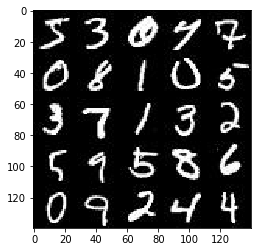

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

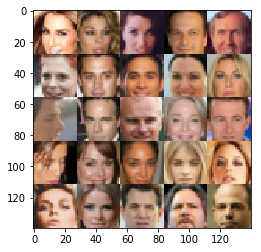

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [34]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None))
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [35]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    n_units, alpha = 256, 0.01 # hyperparameters
    images = tf.contrib.layers.flatten(images)

    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(images, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [36]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    n_units, alpha = 256, 0.01
    z = tf.contrib.layers.flatten(z)
    outdim = 28 * 28 * out_channel_dim
    with tf.variable_scope('generator', reuse=not is_train):
        h1 = tf.layers.dense(z, n_units, activation=None)
        h1 = tf.maximum(alpha * h1, h1)
        logits = tf.layers.dense(h1, outdim, activation=None)
        out = tf.tanh(logits)
        out = tf.reshape(out, [-1, 28, 28, out_channel_dim])
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [37]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    _, d_logits_real = discriminator(input_real, reuse=False)
    input_fake = generator(input_z, out_channel_dim, is_train=True)
    _, d_logits_fake = discriminator(input_fake, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real,
            labels=tf.ones_like(d_logits_real) * (1 - smooth)
        )
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.zeros_like(d_logits_real)
        ))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_logits_fake)
        )
    )
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [58]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [59]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [75]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    image_width, image_height, image_channels = data_shape[1], data_shape[2], data_shape[3]
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_i, batch_images in enumerate(get_batches(batch_size)):
                batch_real = batch_images*2 - 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                sess.run(d_train_opt, feed_dict={
                    input_real: batch_real,
                    input_z: batch_z,
                    lr: learning_rate
                })
                sess.run(g_train_opt, feed_dict={
                    input_z: batch_z,
                    lr: learning_rate
                })

                # At the end of each epoch, get the losses and print them out
                train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                train_loss_g = g_loss.eval({input_z: batch_z})
                if batch_i > 0 and batch_i % 50 == 0:
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))    
                if batch_i > 0 and batch_i % 200 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
            print('Epoch {} done.'.format(epoch_i+1))
            show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/5... Discriminator Loss: 1.3592... Generator Loss: 0.8882
Epoch 1/5... Discriminator Loss: 1.4696... Generator Loss: 0.5041
Epoch 1/5... Discriminator Loss: 1.3325... Generator Loss: 0.7068
Epoch 1/5... Discriminator Loss: 1.3858... Generator Loss: 0.5390


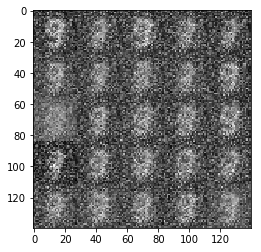

Epoch 2/5... Discriminator Loss: 1.4620... Generator Loss: 0.4916
Epoch 2/5... Discriminator Loss: 1.2695... Generator Loss: 0.9593
Epoch 2/5... Discriminator Loss: 1.3842... Generator Loss: 0.7199
Epoch 2/5... Discriminator Loss: 1.3999... Generator Loss: 0.6585


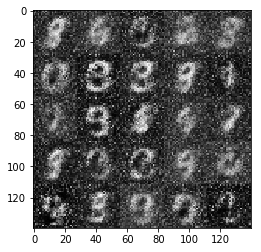

Epoch 3/5... Discriminator Loss: 1.3623... Generator Loss: 0.8406
Epoch 3/5... Discriminator Loss: 1.4995... Generator Loss: 0.6497
Epoch 3/5... Discriminator Loss: 1.4008... Generator Loss: 0.8195
Epoch 3/5... Discriminator Loss: 1.3684... Generator Loss: 0.9285


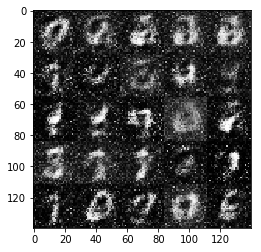

Epoch 4/5... Discriminator Loss: 1.3588... Generator Loss: 0.8834
Epoch 4/5... Discriminator Loss: 1.4865... Generator Loss: 0.6717
Epoch 4/5... Discriminator Loss: 1.3608... Generator Loss: 0.9684
Epoch 4/5... Discriminator Loss: 1.3963... Generator Loss: 1.2284


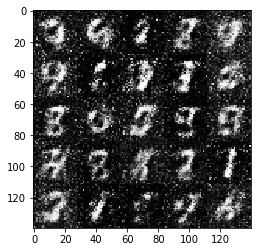

Epoch 5/5... Discriminator Loss: 1.4077... Generator Loss: 0.8302
Epoch 5/5... Discriminator Loss: 1.5103... Generator Loss: 0.6266
Epoch 5/5... Discriminator Loss: 1.3505... Generator Loss: 0.9575
Epoch 5/5... Discriminator Loss: 1.4277... Generator Loss: 1.3898


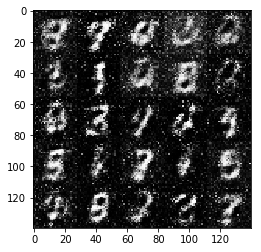

Epoch 5 done.


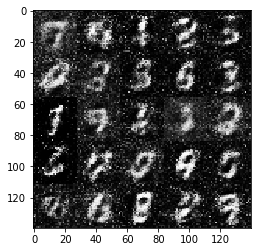

In [90]:
batch_size = 256
z_dim = 100
learning_rate = 0.001
beta1 = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/5... Discriminator Loss: 0.6680... Generator Loss: 1.5782
Epoch 1/5... Discriminator Loss: 0.7496... Generator Loss: 1.3179
Epoch 1/5... Discriminator Loss: 0.7232... Generator Loss: 1.8382
Epoch 1/5... Discriminator Loss: 0.7472... Generator Loss: 2.3565


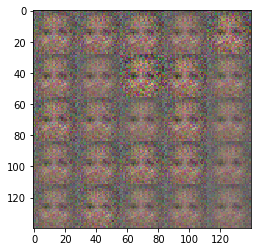

Epoch 1/5... Discriminator Loss: 0.9635... Generator Loss: 1.6062
Epoch 1/5... Discriminator Loss: 0.7715... Generator Loss: 1.1386
Epoch 1/5... Discriminator Loss: 0.8263... Generator Loss: 1.4985
Epoch 1/5... Discriminator Loss: 0.8886... Generator Loss: 1.6872


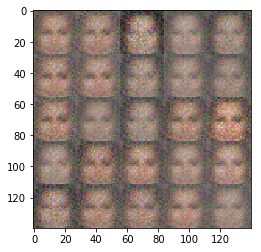

Epoch 1/5... Discriminator Loss: 1.1904... Generator Loss: 2.0929
Epoch 1/5... Discriminator Loss: 0.9079... Generator Loss: 1.8638
Epoch 1/5... Discriminator Loss: 0.9622... Generator Loss: 1.9566
Epoch 1/5... Discriminator Loss: 1.2039... Generator Loss: 0.9057


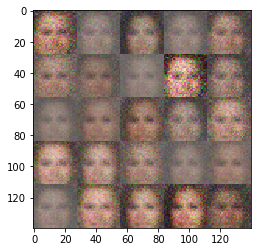

Epoch 1/5... Discriminator Loss: 1.0023... Generator Loss: 1.3791
Epoch 1/5... Discriminator Loss: 0.8810... Generator Loss: 1.7399
Epoch 1/5... Discriminator Loss: 1.0576... Generator Loss: 2.1155
Epoch 1/5... Discriminator Loss: 1.1220... Generator Loss: 1.9255


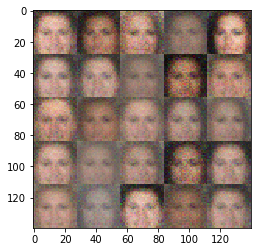

Epoch 1/5... Discriminator Loss: 1.1659... Generator Loss: 2.0499
Epoch 1/5... Discriminator Loss: 1.2364... Generator Loss: 1.0352
Epoch 1/5... Discriminator Loss: 1.3221... Generator Loss: 2.1592
Epoch 1/5... Discriminator Loss: 1.2326... Generator Loss: 1.8893


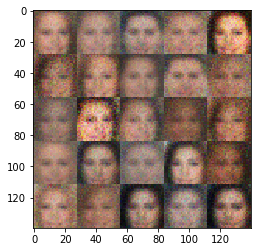

Epoch 1/5... Discriminator Loss: 1.2115... Generator Loss: 2.0840
Epoch 1/5... Discriminator Loss: 1.3361... Generator Loss: 1.5315
Epoch 1/5... Discriminator Loss: 1.3667... Generator Loss: 1.1723
Epoch 1/5... Discriminator Loss: 1.4214... Generator Loss: 2.3518


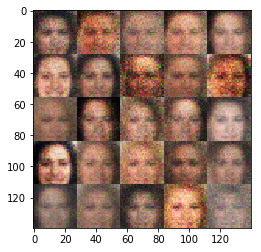

Epoch 1/5... Discriminator Loss: 1.7445... Generator Loss: 0.9390
Epoch 1/5... Discriminator Loss: 1.5531... Generator Loss: 1.6461
Epoch 1/5... Discriminator Loss: 1.5152... Generator Loss: 1.5819
Epoch 1/5... Discriminator Loss: 1.4259... Generator Loss: 1.3896


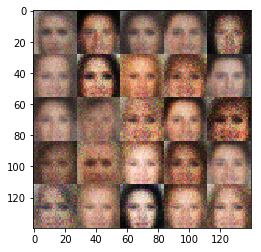

Epoch 1/5... Discriminator Loss: 1.2917... Generator Loss: 1.6135
Epoch 1/5... Discriminator Loss: 1.6304... Generator Loss: 0.8255
Epoch 1/5... Discriminator Loss: 1.4818... Generator Loss: 1.4870
Epoch 2/5... Discriminator Loss: 1.6125... Generator Loss: 1.1933
Epoch 2/5... Discriminator Loss: 1.4857... Generator Loss: 1.2704
Epoch 2/5... Discriminator Loss: 1.7944... Generator Loss: 0.9922
Epoch 2/5... Discriminator Loss: 1.4666... Generator Loss: 1.1806


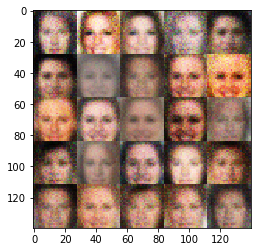

Epoch 2/5... Discriminator Loss: 1.6067... Generator Loss: 1.6021
Epoch 2/5... Discriminator Loss: 1.4627... Generator Loss: 1.0129
Epoch 2/5... Discriminator Loss: 1.7337... Generator Loss: 1.1165
Epoch 2/5... Discriminator Loss: 1.5429... Generator Loss: 2.0437


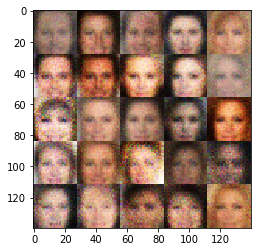

Epoch 2/5... Discriminator Loss: 1.9953... Generator Loss: 0.5560
Epoch 2/5... Discriminator Loss: 1.5112... Generator Loss: 1.3585
Epoch 2/5... Discriminator Loss: 1.6583... Generator Loss: 1.2003
Epoch 2/5... Discriminator Loss: 1.5524... Generator Loss: 0.9433


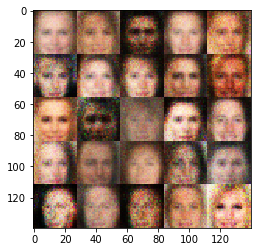

Epoch 2/5... Discriminator Loss: 1.6187... Generator Loss: 1.2908
Epoch 2/5... Discriminator Loss: 1.5343... Generator Loss: 0.9859
Epoch 2/5... Discriminator Loss: 1.4782... Generator Loss: 1.2235
Epoch 2/5... Discriminator Loss: 1.5360... Generator Loss: 1.3475


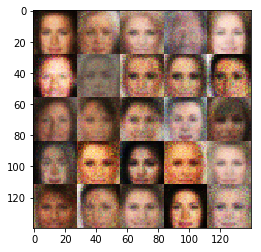

Epoch 2/5... Discriminator Loss: 1.6856... Generator Loss: 1.2178
Epoch 2/5... Discriminator Loss: 1.4065... Generator Loss: 1.5296
Epoch 2/5... Discriminator Loss: 1.6300... Generator Loss: 1.4628
Epoch 2/5... Discriminator Loss: 1.5908... Generator Loss: 1.3655


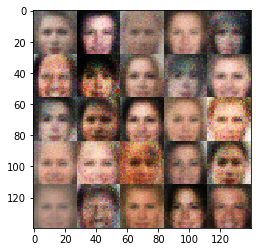

Epoch 2/5... Discriminator Loss: 1.4852... Generator Loss: 1.2918
Epoch 2/5... Discriminator Loss: 1.9325... Generator Loss: 0.5566
Epoch 2/5... Discriminator Loss: 1.6308... Generator Loss: 2.4446
Epoch 2/5... Discriminator Loss: 1.5028... Generator Loss: 1.0012


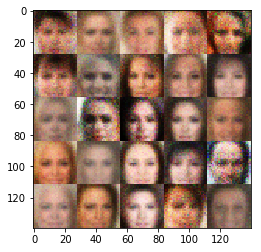

Epoch 2/5... Discriminator Loss: 1.4670... Generator Loss: 1.2243
Epoch 2/5... Discriminator Loss: 1.6089... Generator Loss: 1.3430
Epoch 2/5... Discriminator Loss: 1.4432... Generator Loss: 1.4833
Epoch 2/5... Discriminator Loss: 1.5738... Generator Loss: 1.0024


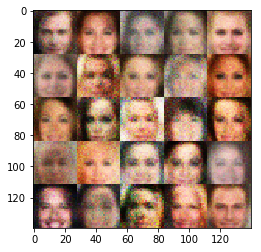

Epoch 2/5... Discriminator Loss: 1.6086... Generator Loss: 1.0123
Epoch 2/5... Discriminator Loss: 1.5674... Generator Loss: 1.3253
Epoch 2/5... Discriminator Loss: 1.3867... Generator Loss: 1.4563
Epoch 3/5... Discriminator Loss: 1.3766... Generator Loss: 1.4294
Epoch 3/5... Discriminator Loss: 1.8446... Generator Loss: 0.7610
Epoch 3/5... Discriminator Loss: 1.5886... Generator Loss: 1.2850
Epoch 3/5... Discriminator Loss: 1.6797... Generator Loss: 0.9544


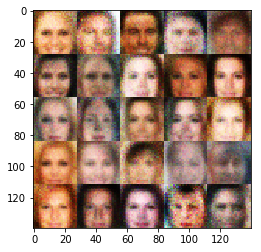

Epoch 3/5... Discriminator Loss: 1.5290... Generator Loss: 1.1740
Epoch 3/5... Discriminator Loss: 1.5215... Generator Loss: 0.9551
Epoch 3/5... Discriminator Loss: 1.5614... Generator Loss: 1.0403
Epoch 3/5... Discriminator Loss: 2.2665... Generator Loss: 0.3850


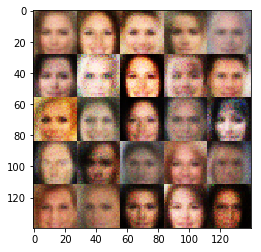

Epoch 3/5... Discriminator Loss: 1.4045... Generator Loss: 1.2266
Epoch 3/5... Discriminator Loss: 1.7511... Generator Loss: 0.7435
Epoch 3/5... Discriminator Loss: 1.4446... Generator Loss: 1.2160
Epoch 3/5... Discriminator Loss: 1.6335... Generator Loss: 1.0066


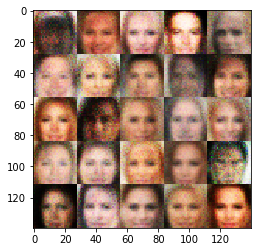

Epoch 3/5... Discriminator Loss: 1.6956... Generator Loss: 0.9294
Epoch 3/5... Discriminator Loss: 1.5064... Generator Loss: 1.3307
Epoch 3/5... Discriminator Loss: 1.5421... Generator Loss: 1.0404
Epoch 3/5... Discriminator Loss: 1.4492... Generator Loss: 1.2177


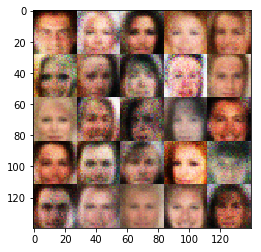

Epoch 3/5... Discriminator Loss: 1.5320... Generator Loss: 1.0554
Epoch 3/5... Discriminator Loss: 1.4793... Generator Loss: 1.4475
Epoch 3/5... Discriminator Loss: 1.5122... Generator Loss: 1.2579
Epoch 3/5... Discriminator Loss: 1.6136... Generator Loss: 1.0267


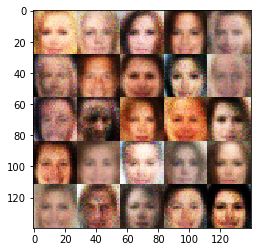

Epoch 3/5... Discriminator Loss: 1.5675... Generator Loss: 0.8981
Epoch 3/5... Discriminator Loss: 1.4556... Generator Loss: 1.2192
Epoch 3/5... Discriminator Loss: 1.4831... Generator Loss: 1.0466
Epoch 3/5... Discriminator Loss: 1.4787... Generator Loss: 0.9840


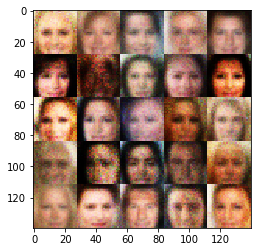

Epoch 3/5... Discriminator Loss: 1.5094... Generator Loss: 0.9477
Epoch 3/5... Discriminator Loss: 1.4702... Generator Loss: 1.1133
Epoch 3/5... Discriminator Loss: 1.5068... Generator Loss: 1.1405
Epoch 3/5... Discriminator Loss: 1.5724... Generator Loss: 1.0504


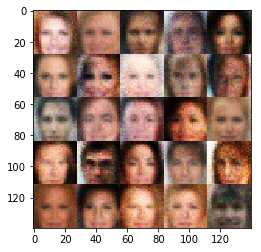

Epoch 3/5... Discriminator Loss: 1.5054... Generator Loss: 0.9709
Epoch 3/5... Discriminator Loss: 1.4755... Generator Loss: 1.0889
Epoch 3/5... Discriminator Loss: 1.5446... Generator Loss: 0.9069
Epoch 4/5... Discriminator Loss: 1.5639... Generator Loss: 0.9233
Epoch 4/5... Discriminator Loss: 1.5253... Generator Loss: 1.0255
Epoch 4/5... Discriminator Loss: 1.4822... Generator Loss: 0.9440
Epoch 4/5... Discriminator Loss: 1.5103... Generator Loss: 0.9644


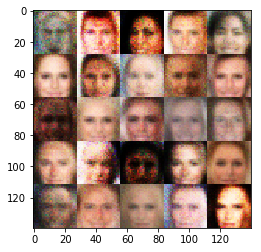

Epoch 4/5... Discriminator Loss: 1.4807... Generator Loss: 1.1062
Epoch 4/5... Discriminator Loss: 1.6536... Generator Loss: 0.6830
Epoch 4/5... Discriminator Loss: 1.5455... Generator Loss: 0.7785
Epoch 4/5... Discriminator Loss: 1.4038... Generator Loss: 1.0622


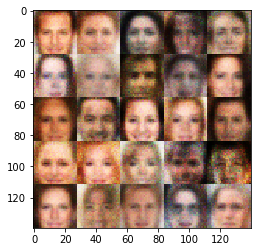

Epoch 4/5... Discriminator Loss: 1.5238... Generator Loss: 0.8156
Epoch 4/5... Discriminator Loss: 1.4631... Generator Loss: 0.9811
Epoch 4/5... Discriminator Loss: 1.4522... Generator Loss: 0.9139
Epoch 4/5... Discriminator Loss: 1.4932... Generator Loss: 0.8796


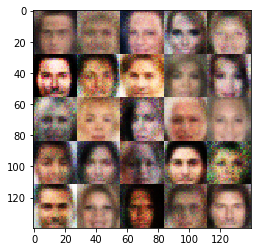

Epoch 4/5... Discriminator Loss: 1.4426... Generator Loss: 0.9979
Epoch 4/5... Discriminator Loss: 1.4361... Generator Loss: 1.0521
Epoch 4/5... Discriminator Loss: 1.3814... Generator Loss: 1.0841
Epoch 4/5... Discriminator Loss: 1.3702... Generator Loss: 1.0655


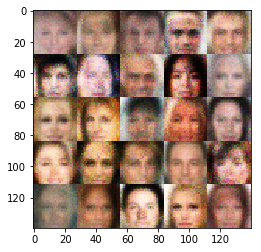

Epoch 4/5... Discriminator Loss: 1.4966... Generator Loss: 0.8320
Epoch 4/5... Discriminator Loss: 1.5219... Generator Loss: 0.8801
Epoch 4/5... Discriminator Loss: 1.4459... Generator Loss: 0.9207
Epoch 4/5... Discriminator Loss: 1.3617... Generator Loss: 1.3590


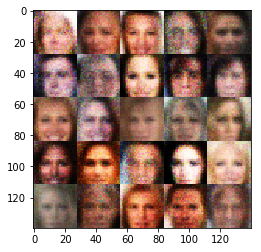

Epoch 4/5... Discriminator Loss: 1.4123... Generator Loss: 1.0321
Epoch 4/5... Discriminator Loss: 1.5364... Generator Loss: 0.7707
Epoch 4/5... Discriminator Loss: 1.4718... Generator Loss: 0.9796
Epoch 4/5... Discriminator Loss: 1.4980... Generator Loss: 0.8805


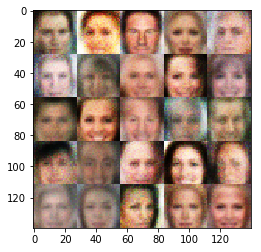

Epoch 4/5... Discriminator Loss: 1.4713... Generator Loss: 0.8496
Epoch 4/5... Discriminator Loss: 1.4765... Generator Loss: 1.0015
Epoch 4/5... Discriminator Loss: 1.4448... Generator Loss: 0.9953
Epoch 4/5... Discriminator Loss: 1.4656... Generator Loss: 0.8764


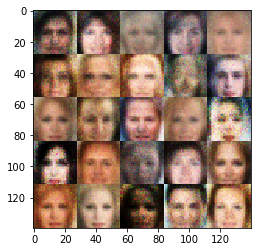

Epoch 4/5... Discriminator Loss: 1.4207... Generator Loss: 0.9381
Epoch 4/5... Discriminator Loss: 1.4859... Generator Loss: 0.8818
Epoch 4/5... Discriminator Loss: 1.4577... Generator Loss: 0.9614
Epoch 5/5... Discriminator Loss: 1.5391... Generator Loss: 0.7647
Epoch 5/5... Discriminator Loss: 1.5156... Generator Loss: 0.8714
Epoch 5/5... Discriminator Loss: 1.3962... Generator Loss: 1.1054
Epoch 5/5... Discriminator Loss: 1.4436... Generator Loss: 1.0219


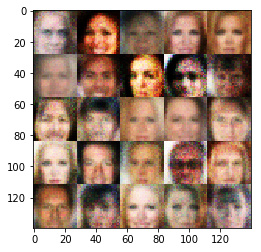

Epoch 5/5... Discriminator Loss: 1.4358... Generator Loss: 1.2641
Epoch 5/5... Discriminator Loss: 1.4523... Generator Loss: 0.8291
Epoch 5/5... Discriminator Loss: 1.4696... Generator Loss: 0.9342
Epoch 5/5... Discriminator Loss: 1.4396... Generator Loss: 0.8761


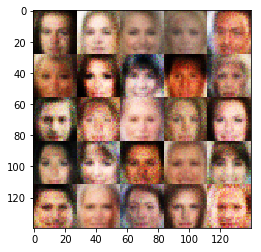

Epoch 5/5... Discriminator Loss: 1.4863... Generator Loss: 0.8640
Epoch 5/5... Discriminator Loss: 1.4237... Generator Loss: 1.0379
Epoch 5/5... Discriminator Loss: 1.4359... Generator Loss: 0.9185
Epoch 5/5... Discriminator Loss: 1.5366... Generator Loss: 0.9121


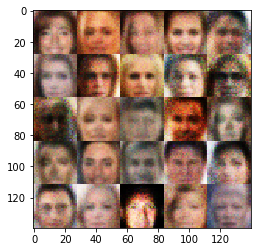

Epoch 5/5... Discriminator Loss: 1.3842... Generator Loss: 1.0318
Epoch 5/5... Discriminator Loss: 1.3836... Generator Loss: 1.1566
Epoch 5/5... Discriminator Loss: 1.4942... Generator Loss: 0.9417
Epoch 5/5... Discriminator Loss: 1.4325... Generator Loss: 0.9537


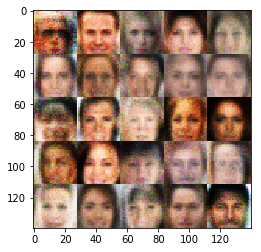

Epoch 5/5... Discriminator Loss: 1.4374... Generator Loss: 0.9627
Epoch 5/5... Discriminator Loss: 1.4400... Generator Loss: 0.9549
Epoch 5/5... Discriminator Loss: 1.4074... Generator Loss: 1.0814
Epoch 5/5... Discriminator Loss: 1.4250... Generator Loss: 1.0802


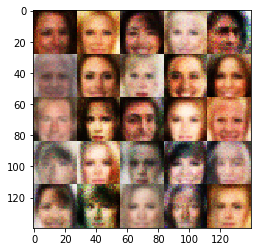

Epoch 5/5... Discriminator Loss: 1.4826... Generator Loss: 0.8944
Epoch 5/5... Discriminator Loss: 1.6049... Generator Loss: 0.6926
Epoch 5/5... Discriminator Loss: 1.4477... Generator Loss: 1.0629
Epoch 5/5... Discriminator Loss: 1.3899... Generator Loss: 0.9880


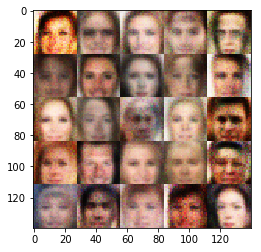

Epoch 5/5... Discriminator Loss: 1.5633... Generator Loss: 0.7607
Epoch 5/5... Discriminator Loss: 1.4999... Generator Loss: 0.8721
Epoch 5/5... Discriminator Loss: 1.4720... Generator Loss: 0.9794
Epoch 5/5... Discriminator Loss: 1.4594... Generator Loss: 0.8943


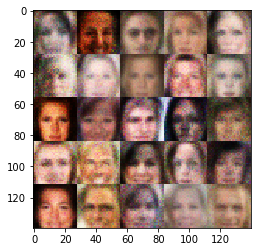

Epoch 5/5... Discriminator Loss: 1.4387... Generator Loss: 0.8929
Epoch 5/5... Discriminator Loss: 1.3642... Generator Loss: 1.0763
Epoch 5/5... Discriminator Loss: 1.4428... Generator Loss: 0.9627
Epoch 5 done.


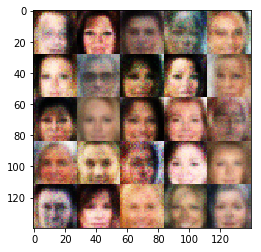

In [94]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.6

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.